In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator, CubicSpline, UnivariateSpline
from scipy.optimize import minimize_scalar, differential_evolution

import math

import pickle

from easygsvd import gsvd as gsvd_func
from easygsvd import random_rank_matrix

from scipy.sparse.linalg import LinearOperator

from scipy.linalg import qr, qr_insert
import scipy.sparse.linalg as splinalg

import scipy.sparse as sps

import jlinops

import time

from fastprogress import progress_bar

import os
import sys
sys.path.append("../")
sys.path.append("../..")

import dill

import shutil

from scipy.sparse.linalg import aslinearoperator

from pytikhonov import lcorner, TikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function
from pytikhonov import ProjectedTikhonovFamily


from pinv import FullRowRankDenseWeightedPinvFactory
from hybridpro import HybridProjectionIRLSSolver

In [2]:
# Problem parameters
blur_sigma = 8.0

xtrue = jlinops.piecewise_constant_1d_test_problem()
N = len(xtrue)
A = jlinops.Gaussian1DBlurOperator(N, blur_sigma=blur_sigma, mode="constant")
A = jlinops.black_box_to_dense(A)
#A = A[::2,:]
noise_sigma = 1e-1
btrue = A @ xtrue
np.random.seed(0)
noise_vec = noise_sigma*np.random.normal(size=len(btrue))
b = btrue + noise_vec  # signal and noise
#b = noise_vec.copy() # pure noise
L, _ = jlinops.first_order_derivative_1d(N, boundary="none")
L = L.toarray()


# Should we do L1?
do_l1 = False
if do_l1:
    def mm_weights(x, epsilon, p):
        z = (x**2 + epsilon**2)**( (p-2.0)/2.0 )
        return z

    l1_epsilon = 1e-3
    l1_weighting_rule = lambda Lx, lambdah: np.sqrt(mm_weights(Lx, l1_epsilon, 1.0))
    w_true = l1_weighting_rule(L @ xtrue, 1.0)
    L = np.diag(w_true) @ L



# define tikhonov family
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
gsvd = tf.gsvd

# Test it out

In [3]:
# MM weights
def mm_weights(x, epsilon, p):
    z = (x**2 + epsilon**2)**( (p-2.0)/2.0 )
    return z

l1_epsilon = 1e-6
l1_weighting_rule = lambda Lx, lambdah: np.sqrt(mm_weights(Lx, l1_epsilon, 1.0))

WLpinv_factory = FullRowRankDenseWeightedPinvFactory(L, None, L)

Lkermat = np.ones(L.shape[1])
Lkermat /= np.linalg.norm(Lkermat)
Lkermat = Lkermat[:,None]

gks_solver = HybridProjectionIRLSSolver(A, L, b, noise_var=noise_sigma**2, weighting_rule=None)
sgks_solver = HybridProjectionIRLSSolver(A, L, b, noise_var=noise_sigma**2, weighting_rule=l1_weighting_rule)
psgks_solver = HybridProjectionIRLSSolver(A, L, b, noise_var=noise_sigma**2, weighting_rule=l1_weighting_rule, Lkermat=Lkermat, WLpinv_factory=WLpinv_factory)
fgk_solver = HybridProjectionIRLSSolver(A, L, b, noise_var=noise_sigma**2, weighting_rule=l1_weighting_rule, Lkermat=Lkermat, WLpinv_factory=WLpinv_factory)

In [4]:
n_iters = 100
n_iters_res = 100
restart_dim = 25
gen_plots = True

# Run GKS with all regparam methods
gks_dp_data = gks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots)
gks_lcorner_data = gks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots)
gks_gcv_data = gks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="gcv", xtrue=xtrue, x0=None, gen_plots=gen_plots)

# Run S-GKS with all regparam methods
sgks_dp_data = sgks_solver.solve(n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots)
sgks_lcorner_data = sgks_solver.solve(n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots)
sgks_gcv_data = sgks_solver.solve(n_iters=n_iters, regparam="gcv", xtrue=xtrue, x0=None, gen_plots=gen_plots)

# Restarted S-GKS
res0sgks_dp_data = sgks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=0)
res1sgks_dp_data = sgks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=1)
res0sgks_lcorner_data = sgks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=0)
res1sgks_lcorner_data = sgks_solver.solve(projection_method="sgks", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=1)

# PS-GKS
psgks_dp_data = psgks_solver.solve(projection_method="psgks", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots)
psgks_lcorner_data = psgks_solver.solve(projection_method="psgks", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots)

# FGK
fgk_dp_data = fgk_solver.solve(projection_method="fgk", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots)
fgk_lcorner_data = fgk_solver.solve(projection_method="fgk", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots)

# Restarted PS-GKS
res0psgks_dp_data = psgks_solver.solve(projection_method="psgks", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=0)
res0psgks_lcorner_data = psgks_solver.solve(projection_method="psgks", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=0)
res1psgks_dp_data = psgks_solver.solve(projection_method="psgks", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=1)
res1psgks_lcorner_data = psgks_solver.solve(projection_method="psgks", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=1)

# Restarted FGK
res0fgk_dp_data = fgk_solver.solve(projection_method="fgk", n_iters=n_iters, regparam="dp", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=0)
res0fgk_lcorner_data = fgk_solver.solve(projection_method="fgk", n_iters=n_iters, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=gen_plots, restart_dim=restart_dim, restart_style=0)

DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12


DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12


DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12
DP rootfinder broke, there is no root! Returning lambdah = 1e-12


# Restarted flexible?

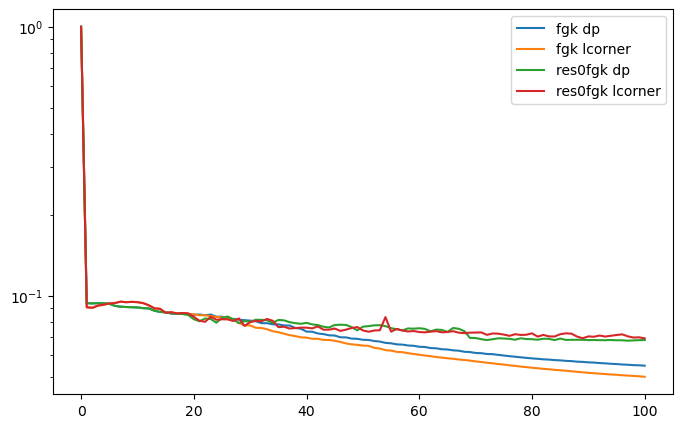

In [13]:
plt.figure(figsize=(8,5))
plt.plot(fgk_dp_data["rel_errs"], label="fgk dp")
plt.plot(fgk_lcorner_data["rel_errs"], label="fgk lcorner")
plt.plot(res0fgk_dp_data["rel_errs"], label="res0fgk dp")
plt.plot(res0fgk_lcorner_data["rel_errs"], label="res0fgk lcorner")
plt.yscale("log")
plt.legend()
plt.show()

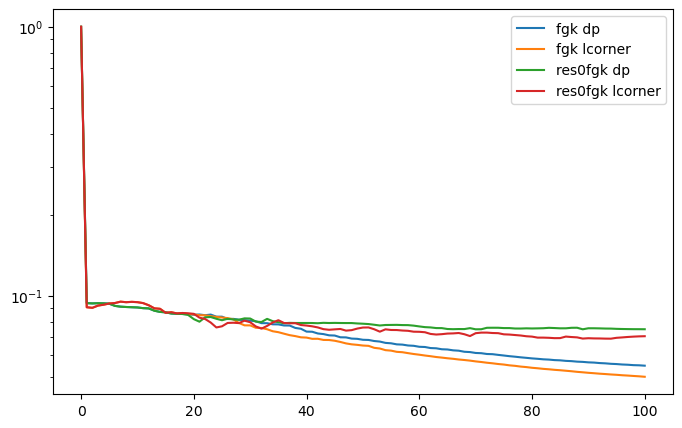

In [276]:
plt.figure(figsize=(8,5))
plt.plot(fgk_dp_data["rel_errs"], label="fgk dp")
plt.plot(fgk_lcorner_data["rel_errs"], label="fgk lcorner")
plt.plot(res0fgk_dp_data["rel_errs"], label="res0fgk dp")
plt.plot(res0fgk_lcorner_data["rel_errs"], label="res0fgk lcorner")
plt.yscale("log")
plt.legend()
plt.show()

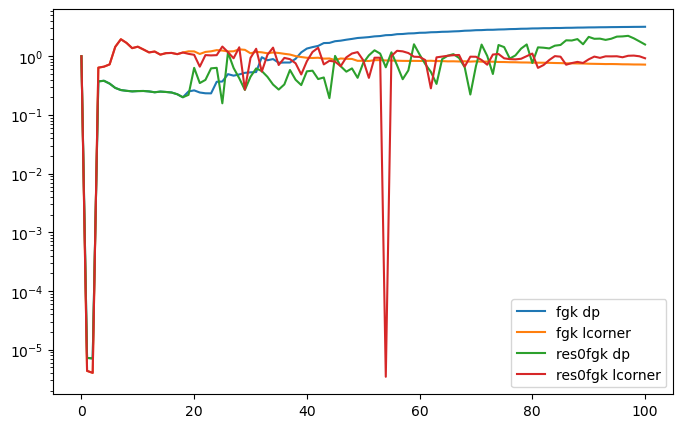

In [301]:
plt.figure(figsize=(8,5))
plt.plot(fgk_dp_data["lambdahs"], label="fgk dp")
plt.plot(fgk_lcorner_data["lambdahs"], label="fgk lcorner")
plt.plot(res0fgk_dp_data["lambdahs"], label="res0fgk dp")
plt.plot(res0fgk_lcorner_data["lambdahs"], label="res0fgk lcorner")
plt.yscale("log")
plt.legend()
plt.show()

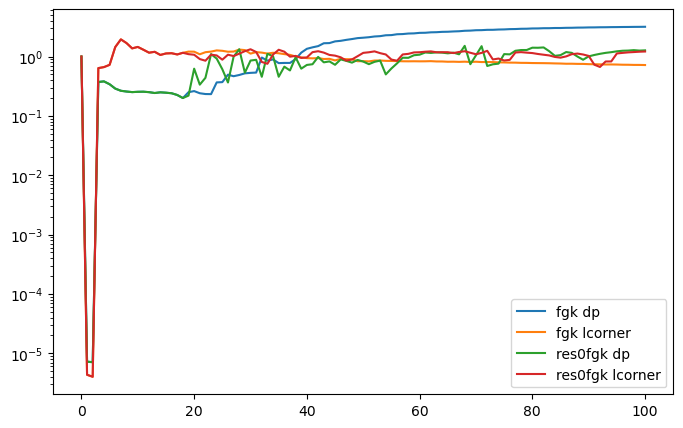

In [277]:
plt.figure(figsize=(8,5))
plt.plot(fgk_dp_data["lambdahs"], label="fgk dp")
plt.plot(fgk_lcorner_data["lambdahs"], label="fgk lcorner")
plt.plot(res0fgk_dp_data["lambdahs"], label="res0fgk dp")
plt.plot(res0fgk_lcorner_data["lambdahs"], label="res0fgk lcorner")
plt.yscale("log")
plt.legend()
plt.show()

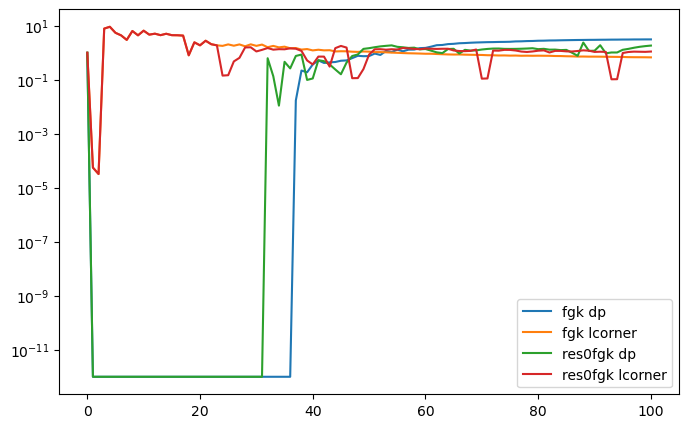

In [260]:
plt.figure(figsize=(8,5))
plt.plot(fgk_dp_data["lambdahs"], label="fgk dp")
plt.plot(fgk_lcorner_data["lambdahs"], label="fgk lcorner")
plt.plot(res0fgk_dp_data["lambdahs"], label="res0fgk dp")
plt.plot(res0fgk_lcorner_data["lambdahs"], label="res0fgk lcorner")
plt.yscale("log")
plt.legend()
plt.show()

In [1]:
plt.semilogy(res0psgks_dp_data["lambdahs"])
plt.semilogy(res0psgks_lcorner_data["lambdahs"])
#plt.semilogy(res1psgks_dp_data["lambdahs"])
plt.show()

NameError: name 'plt' is not defined

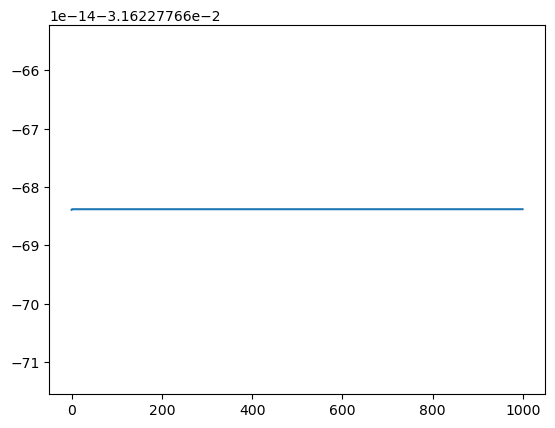

In [311]:
for j in range(1):
    plt.plot(fgk_dp_data["V"][:,j])

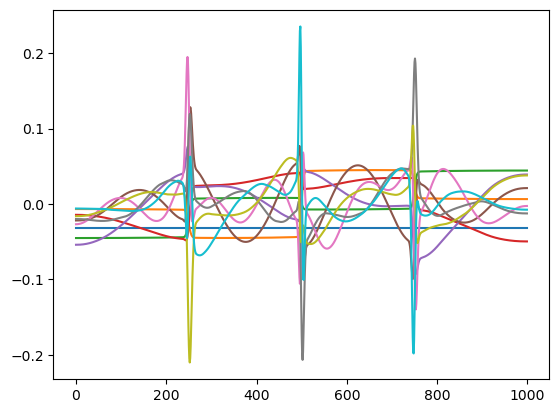

In [309]:
for j in range(10):
    plt.plot(psgks_dp_data["V"][:,j])

# S-GKS and PS-GKS

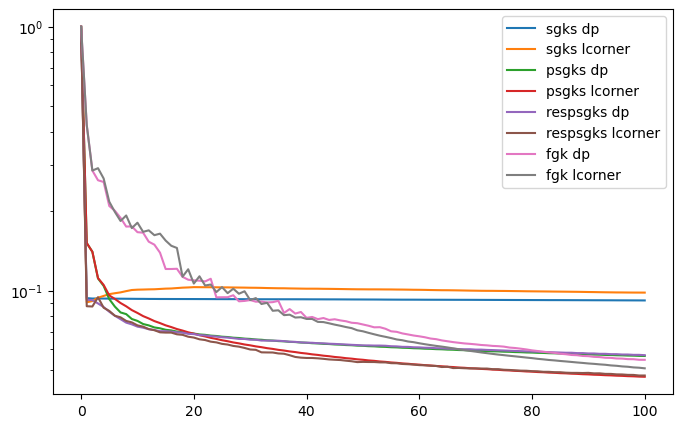

In [252]:
plt.figure(figsize=(8,5))
plt.plot(sgks_dp_data["rel_errs"], label="sgks dp")
plt.plot(sgks_lcorner_data["rel_errs"], label="sgks lcorner")
plt.plot(psgks_dp_data["rel_errs"], label="psgks dp")
plt.plot(psgks_lcorner_data["rel_errs"], label="psgks lcorner")
plt.plot(respsgks_dp_data["rel_errs"], label="respsgks dp")
plt.plot(respsgks_lcorner_data["rel_errs"], label="respsgks lcorner")
plt.plot(fgk_dp_data["rel_errs"], label="fgk dp")
plt.plot(fgk_lcorner_data["rel_errs"], label="fgk lcorner")
#plt.plot(sgks_gcv_data["rel_errs"], label="gcv")
plt.yscale("log")
plt.legend()
plt.show()

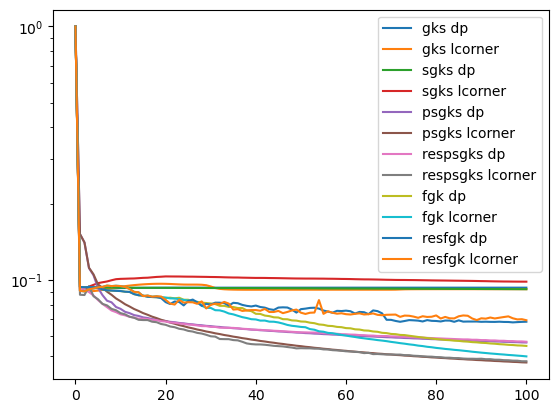

In [314]:
plt.plot(gks_dp_data["rel_errs"], label="gks dp")
plt.plot(gks_lcorner_data["rel_errs"], label="gks lcorner")
plt.plot(sgks_dp_data["rel_errs"], label="sgks dp")
plt.plot(sgks_lcorner_data["rel_errs"], label="sgks lcorner")
plt.plot(psgks_dp_data["rel_errs"], label="psgks dp")
plt.plot(psgks_lcorner_data["rel_errs"], label="psgks lcorner")
plt.plot(respsgks_dp_data["rel_errs"], label="respsgks dp")
plt.plot(respsgks_lcorner_data["rel_errs"], label="respsgks lcorner")
plt.plot(fgk_dp_data["rel_errs"], label="fgk dp")
plt.plot(fgk_lcorner_data["rel_errs"], label="fgk lcorner")
plt.plot(res0fgk_dp_data["rel_errs"], label="resfgk dp")
plt.plot(res0fgk_lcorner_data["rel_errs"], label="resfgk lcorner")
#plt.plot(sgks_gcv_data["rel_errs"], label="gcv")
plt.yscale("log")
plt.legend()
plt.show()

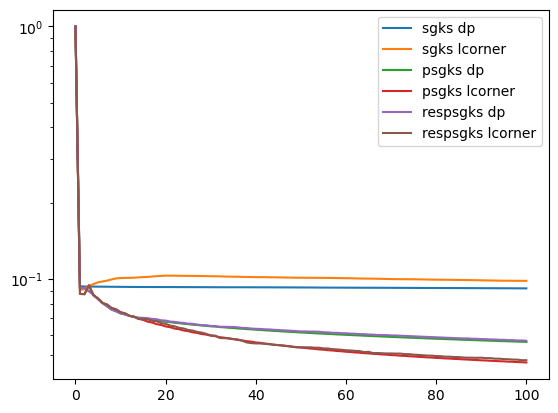

In [ ]:
plt.plot(sgks_dp_data["rel_errs"], label="sgks dp")
plt.plot(sgks_lcorner_data["rel_errs"], label="sgks lcorner")
plt.plot(psgks_dp_data["rel_errs"], label="psgks dp")
plt.plot(psgks_lcorner_data["rel_errs"], label="psgks lcorner")
plt.plot(respsgks_dp_data["rel_errs"], label="respsgks dp")
plt.plot(respsgks_lcorner_data["rel_errs"], label="respsgks lcorner")
#plt.plot(sgks_gcv_data["rel_errs"], label="gcv")
plt.yscale("log")
plt.legend()
plt.show()

In [5]:
respsgks_dp_data["V"].shape

NameError: name 'respsgks_dp_data' is not defined

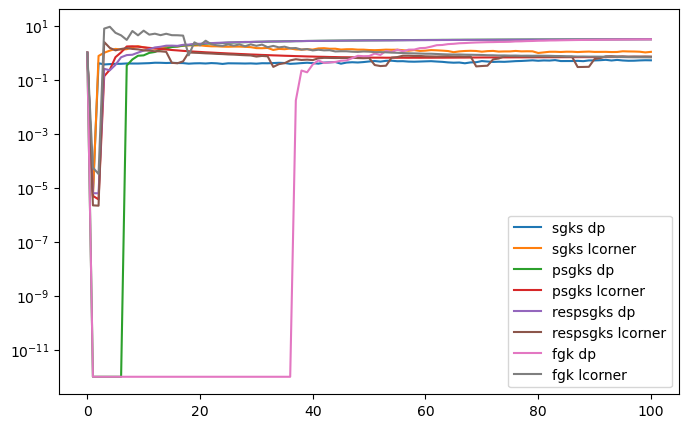

In [256]:
plt.figure(figsize=(8,5))
plt.plot(sgks_dp_data["lambdahs"], label="sgks dp")
plt.plot(sgks_lcorner_data["lambdahs"], label="sgks lcorner")
plt.plot(psgks_dp_data["lambdahs"], label="psgks dp")
plt.plot(psgks_lcorner_data["lambdahs"], label="psgks lcorner")
plt.plot(respsgks_dp_data["lambdahs"], label="respsgks dp")
plt.plot(respsgks_lcorner_data["lambdahs"], label="respsgks lcorner")
plt.plot(fgk_dp_data["lambdahs"], label="fgk dp")
plt.plot(fgk_lcorner_data["lambdahs"], label="fgk lcorner")

#plt.plot(sgks_gcv_data["lambdahs"], label="gcv")
plt.yscale("log")
plt.legend()
plt.show()

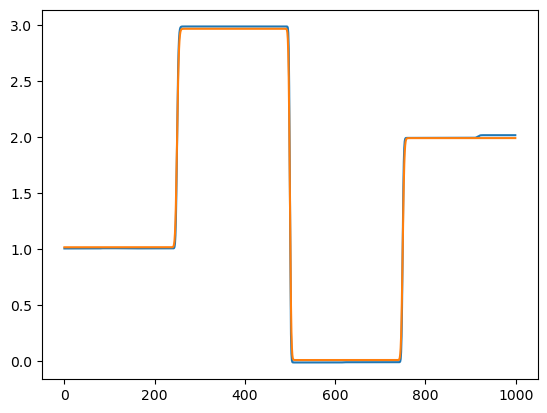

In [259]:
plt.plot(psgks_lcorner_data["x"])
plt.plot(psgks_dp_data["x"])
plt.show()

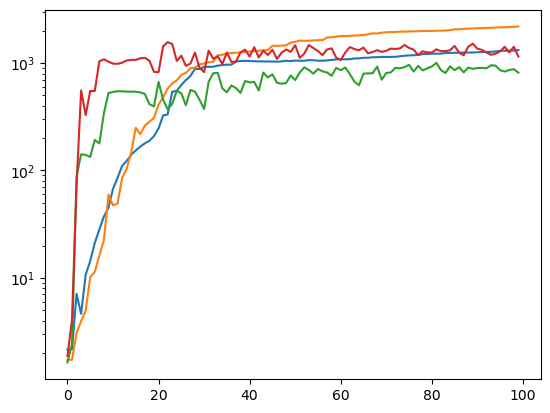

In [87]:
plt.semilogy(psgks_lcorner_data["projected_condition_numbers"])
plt.semilogy(psgks_dp_data["projected_condition_numbers"])
plt.semilogy(sgks_dp_data["projected_condition_numbers"])
plt.semilogy(sgks_lcorner_data["projected_condition_numbers"])
plt.show()

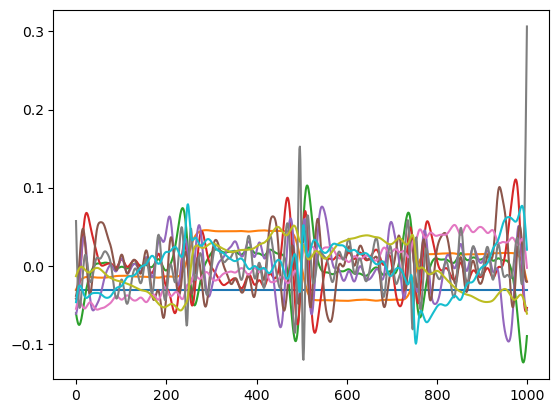

In [95]:
#for j in range(6):
for j in range(10):
    plt.plot(psgks_dp_data["V"][:,j])

# Different restarting techniques?

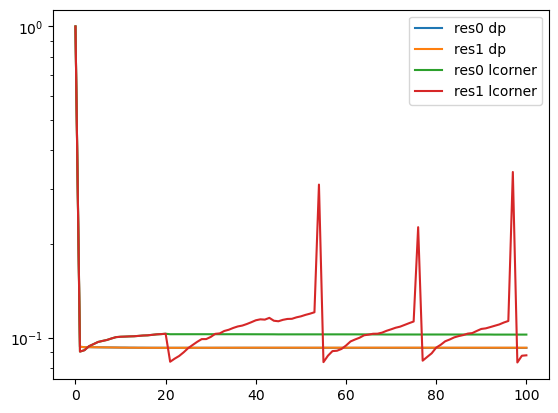

In [157]:
plt.plot( res0sgks_dp_data["rel_errs"], label="res0 dp")
plt.plot( res1sgks_dp_data["rel_errs"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["rel_errs"], label="res0 lcorner")
plt.plot( res1sgks_lcorner_data["rel_errs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

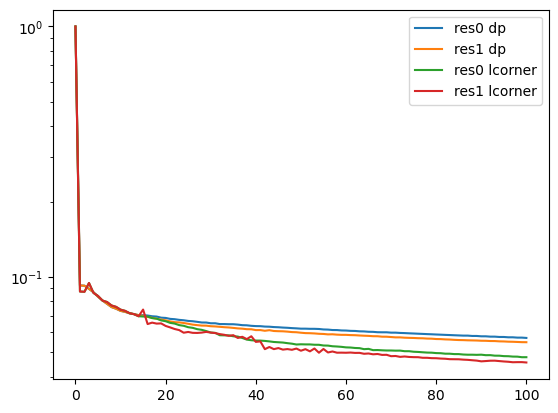

In [158]:
plt.plot( res0psgks_dp_data["rel_errs"], label="res0 dp")
plt.plot( res1psgks_dp_data["rel_errs"], label="res1 dp")
plt.plot( res0psgks_lcorner_data["rel_errs"], label="res0 lcorner")
plt.plot( res1psgks_lcorner_data["rel_errs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

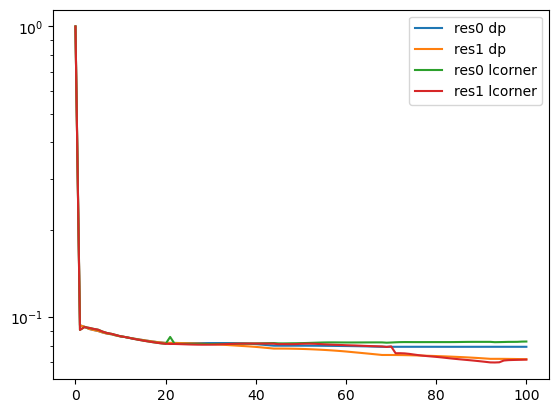

In [53]:
plt.plot( res0sgks_dp_data["rel_errs"], label="res0 dp")
plt.plot( res1sgks_dp_data["rel_errs"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["rel_errs"], label="res0 lcorner")
plt.plot( res1sgks_lcorner_data["rel_errs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

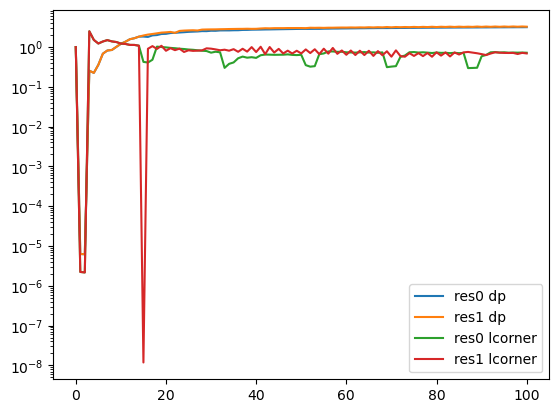

In [161]:
plt.plot( res0psgks_dp_data["lambdahs"], label="res0 dp")
plt.plot( res1psgks_dp_data["lambdahs"], label="res1 dp")
plt.plot( res0psgks_lcorner_data["lambdahs"], label="res0 lcorner")
plt.plot( res1psgks_lcorner_data["lambdahs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

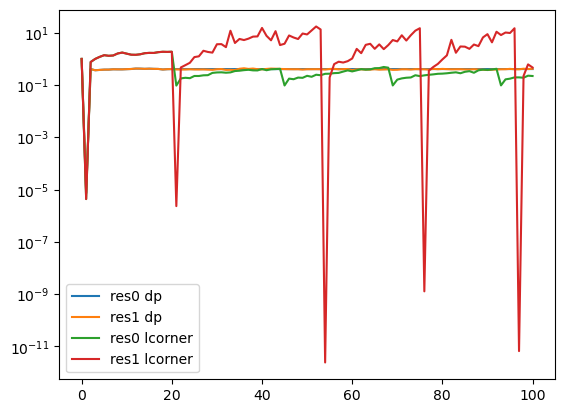

In [159]:
plt.plot( res0sgks_dp_data["lambdahs"], label="res0 dp")
plt.plot( res1sgks_dp_data["lambdahs"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["lambdahs"], label="res0 lcorner")
plt.plot( res1sgks_lcorner_data["lambdahs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

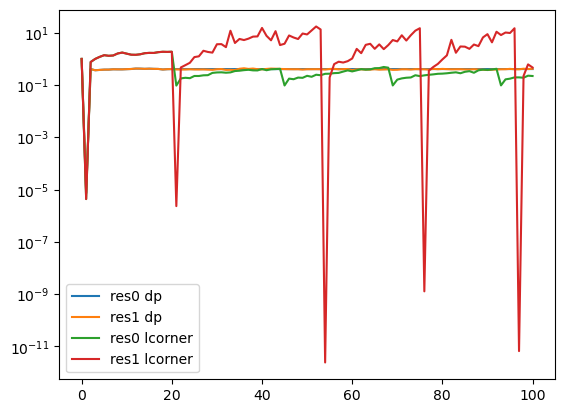

In [162]:
plt.plot( res0sgks_dp_data["lambdahs"], label="res0 dp")
plt.plot( res1sgks_dp_data["lambdahs"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["lambdahs"], label="res0 lcorner")
plt.plot( res1sgks_lcorner_data["lambdahs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

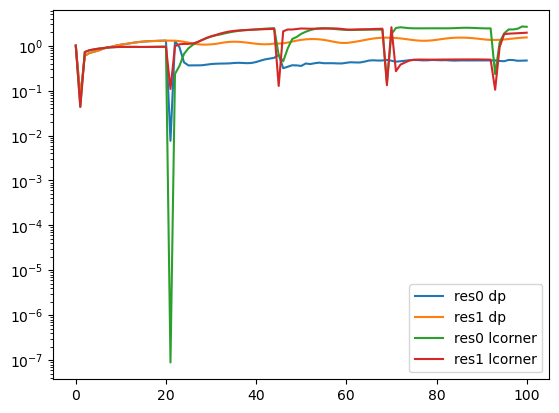

In [54]:
plt.plot( res0sgks_dp_data["lambdahs"], label="res0 dp")
plt.plot( res1sgks_dp_data["lambdahs"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["lambdahs"], label="res0 lcorner")
plt.plot( res1sgks_lcorner_data["lambdahs"], label="res1 lcorner")
plt.legend()
plt.yscale("log")
plt.show()

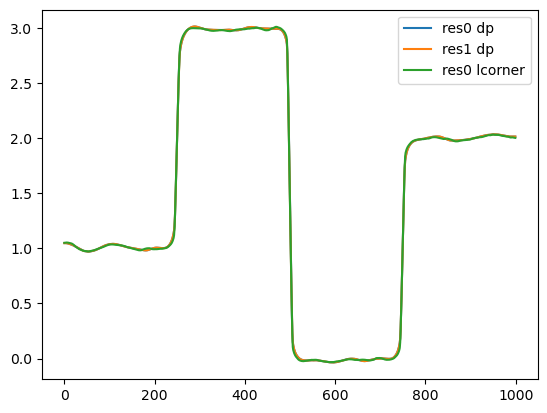

In [112]:
plt.plot( res0sgks_dp_data["x"], label="res0 dp")
plt.plot( res1sgks_dp_data["x"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["x"], label="res0 lcorner")
#plt.plot( res1sgks_lcorner_data["x"], label="res1 lcorner")
plt.legend()
#plt.yscale("log")
plt.show()

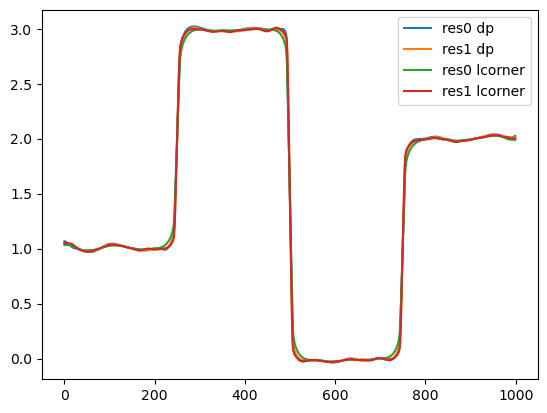

In [55]:
plt.plot( res0sgks_dp_data["x"], label="res0 dp")
plt.plot( res1sgks_dp_data["x"], label="res1 dp")
plt.plot( res0sgks_lcorner_data["x"], label="res0 lcorner")
plt.plot( res1sgks_lcorner_data["x"], label="res1 lcorner")
plt.legend()
#plt.yscale("log")
plt.show()

# Examine S-GKS solution?

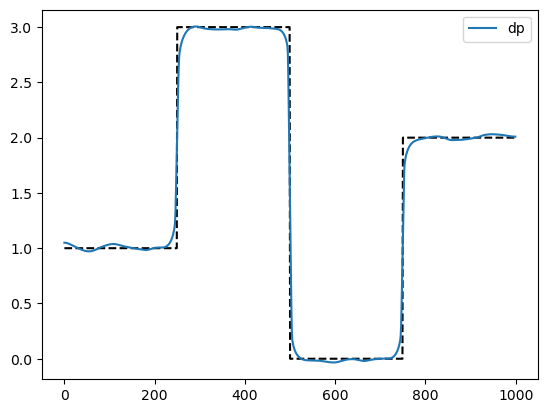

In [32]:
plt.plot(xtrue, color="black", ls="--")
plt.plot(sgks_dp_data["x"], label="dp")
#plt.plot(sgks_lcorner_data["x"], label="lcorner")
#plt.plot(sgks_gcv_data["x"], label="gcv")
plt.legend()
plt.show()

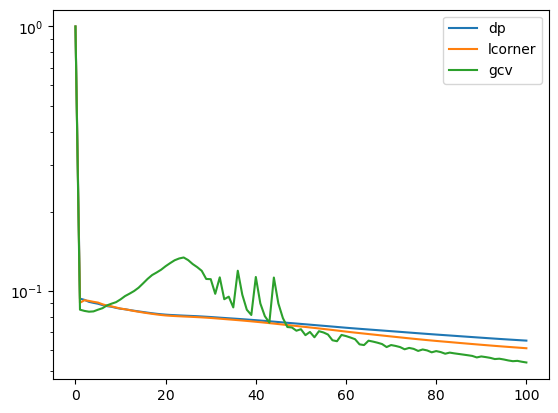

In [33]:
plt.plot(sgks_dp_data["rel_errs"], label="dp")
plt.plot(sgks_lcorner_data["rel_errs"], label="lcorner")
plt.plot(sgks_gcv_data["rel_errs"], label="gcv")
plt.yscale("log")
plt.legend()
plt.show()

# Compare GKS with Full-scale L2?

In [13]:
tikh_family = TikhonovFamily(A, L, b, d=None, noise_var=noise_sigma**2, gsvd=gsvd)

ref_dp_data = discrepancy_principle(tikh_family)
ref_lcorner_data = lcorner(tikh_family)
ref_gcv_data = gcvmin(tikh_family)

ref_dp_lambdah, ref_dp_x_lambdah = ref_dp_data["opt_lambdah"], ref_dp_data["x_lambdah"]
ref_lcorner_lambdah, ref_lcorner_x_lambdah = ref_lcorner_data["opt_lambdah"], ref_lcorner_data["x_lambdah"]
ref_gcv_lambdah, ref_gcv_x_lambdah = ref_gcv_data["opt_lambdah"], ref_gcv_data["x_lambdah"]

ref_dp_rel_err = np.linalg.norm(ref_dp_x_lambdah - xtrue)/np.linalg.norm(xtrue)
ref_lcorner_rel_err = np.linalg.norm(ref_dp_x_lambdah - xtrue)/np.linalg.norm(xtrue)
ref_gcv_rel_err = np.linalg.norm(ref_gcv_x_lambdah - xtrue)/np.linalg.norm(xtrue)

print(f"ref_dp_lambdah: {ref_dp_lambdah}")
print(f"ref_lcorner_lambdah: {ref_dp_lambdah}")
print(f"ref_gcv_lambdah: {ref_gcv_lambdah}")

ref_dp_lambdah: 6.831907457420709
ref_lcorner_lambdah: 6.831907457420709
ref_gcv_lambdah: 0.5479435902132305


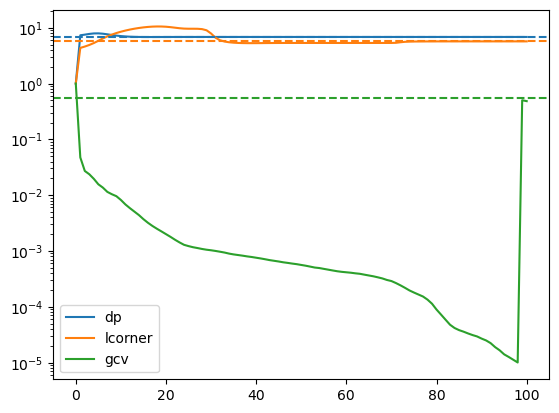

In [14]:
plt.semilogy(gks_dp_data["lambdahs"], label="dp", color="C0")
plt.semilogy(gks_lcorner_data["lambdahs"], label="lcorner", color="C1")
plt.semilogy(gks_gcv_data["lambdahs"], label="gcv", color="C2")

plt.axhline(ref_dp_lambdah, color="C0", ls="--")
plt.axhline(ref_lcorner_lambdah, color="C1", ls="--")
plt.axhline(ref_gcv_lambdah, color="C2", ls="--")

plt.legend()

plt.show()

# OLD

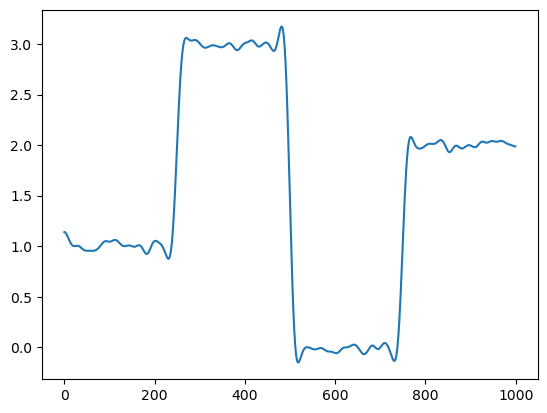

In [56]:
plt.plot(gks_data["x"])
#plt.plot(sgks_data["x"])
plt.show()

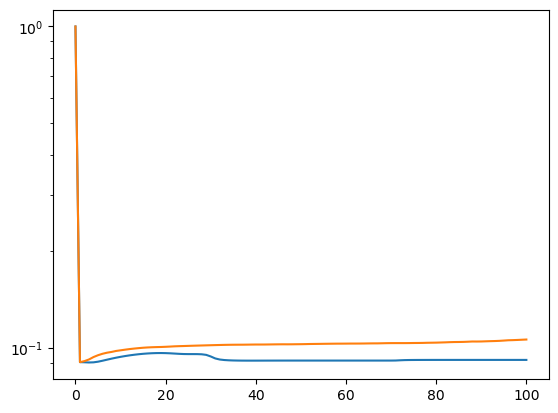

In [55]:
plt.semilogy(gks_data["rel_errs"])
plt.semilogy(sgks_data["rel_errs"])